In [54]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
panel_rent_per_sf_per_neighborhood = pd.read_csv('../data/panel_rent_per_sf_per_neighborhood.csv', index_col=0)
panel = gpd.read_feather('../data/panel_data_estimated_costs.geofeather')
panel_df = pd.merge(panel, panel_rent_per_sf_per_neighborhood)

In [6]:
panel_df.sample(10)[['home_size1', 'year', 'rent/sf', 'assessor_neighborhood']]

,home_size1,year,rent/sf,assessor_neighborhood
667304,1200.0,2013.0,587.519481,Yerba Buena
586877,1388.0,2013.0,290.000000,Bayview
252729,1378.7,2016.0,1191.000000,Russian Hill
379866,1717.5,2014.0,752.000000,Forest Hill Extension
1013171,1250.0,2007.0,559.000000,Outer Mission
518437,1200.0,2014.0,791.000000,Merced Heights
1181346,1387.0,2010.0,389.000000,South of Market
706342,1458.0,2008.0,629.000000,Outer Richmond
522024,1200.0,2014.0,532.000000,Oceanview
777635,1336.0,2016.0,638.000000,Portola


In [7]:
fires = gpd.read_feather('../data/clean_accidental_fires.geofeather')

In [13]:
fires.columns

Index(['geometry', 'number_of_floors_with_significant_damage',
       'number_of_floors_with_heavy_damage',
       'number_of_floors_with_extreme_damage', 'address', 'property_use',
       'estimated_contents_loss', 'estimated_property_loss', 'alarm_dttm',
       'incident_date', 'number_of_floors_with_minimum_damage',
       'number_of_alarms', 'civilian_injuries', 'year'],
      dtype='object')

In [11]:
panel_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
panel_fires = gpd.sjoin(panel_df,
                        fires[['geometry',
                               'estimated_property_loss',
                               'incident_date']].rename(columns= 
                                                        {'estimated_property_loss' : 'fire_damage', 
                                                         'incident_date': 'fire_date'}), 
                        how='left',
                        predicate='contains')

In [23]:
panel_fires.index_right.notna().mean()

0.0023626587023215626

In [27]:
panel_fires = panel_fires.drop(columns=['index_right'])

In [28]:
panel_fires.fire_damage.fillna(0, inplace=True)

In [45]:
(panel_fires.year - panel_fires.fire_date.dt.year).sample(10)

1142101   NaN
1073203   NaN
88072     NaN
1317311   NaN
66560     NaN
198355    NaN
425228    NaN
1186688   NaN
375785    NaN
548385    NaN
dtype: float64

0         NaT
1         NaT
2         NaT
3         NaT
4         NaT
           ..
1328142   NaT
1328143   NaT
1328144   NaT
1328145   NaT
1328146   NaT
Name: fire_date, Length: 1328588, dtype: datetime64[ns]

In [46]:
panel_fires['years_since_fire'] = panel_fires.year - panel_fires.fire_date.dt.year

In [49]:
panel_fires['years_since_fire'][panel_fires['years_since_fire'].notna()]

72         -1.0
116        -7.0
190       -10.0
195       -10.0
1007        5.0
           ... 
1325535     4.0
1326518    -4.0
1327011   -11.0
1327053     4.0
1328110    -8.0
Name: years_since_fire, Length: 3139, dtype: float64

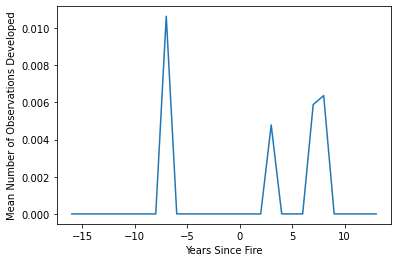

In [51]:
# Compute the mean for each unique value of 'years_since_fire'
plot_data = panel_fires.groupby('years_since_fire')['Developed'].mean().reset_index()

# Plot using seaborn
sns.lineplot(x='years_since_fire', y='Developed', data=plot_data)
plt.ylabel('Mean Number of Observations Developed')
plt.xlabel('Years Since Fire')
plt.show()

In [71]:
 panel_fires.groupby('years_since_fire')['Developed'].agg('count')

years_since_fire
-16.0      4
-15.0     20
-14.0     32
-13.0     46
-12.0     51
-11.0     57
-10.0     72
-9.0      80
-8.0      84
-7.0      94
-6.0     102
-5.0      99
-4.0      98
-3.0      97
-2.0     105
-1.0     124
 0.0     149
 1.0     156
 2.0     187
 3.0     209
 4.0     209
 5.0     192
 6.0     181
 7.0     170
 8.0     157
 9.0     131
 10.0     96
 11.0     79
 12.0     45
 13.0     13
Name: Developed, dtype: int64

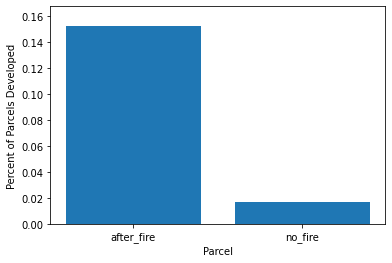

In [67]:
panel_fires['fire_category'] = np.where(panel_fires['years_since_fire'].fillna(-1) < 0, 'no_fire', 'after_fire')

# Compute the mean for each category
plot_data = panel_fires.groupby('fire_category')['Developed'].mean().reset_index()

# Plot using matplotlib
plt.bar(plot_data['fire_category'], plot_data['Developed'] * 100)

# Set y-axis limit to 110% of the maximum value
plt.ylim(0, plot_data['Developed'].max() * 1.10 * 100)

plt.ylabel('Percent of Parcels Developed')
plt.xlabel('Parcel')
plt.show()

In [52]:
panel_fires.groupby('years_since_fire')['Developed'].mean()

years_since_fire
-16.0    0.000000
-15.0    0.000000
-14.0    0.000000
-13.0    0.000000
-12.0    0.000000
-11.0    0.000000
-10.0    0.000000
-9.0     0.000000
-8.0     0.000000
-7.0     0.010638
-6.0     0.000000
-5.0     0.000000
-4.0     0.000000
-3.0     0.000000
-2.0     0.000000
-1.0     0.000000
 0.0     0.000000
 1.0     0.000000
 2.0     0.000000
 3.0     0.004785
 4.0     0.000000
 5.0     0.000000
 6.0     0.000000
 7.0     0.005882
 8.0     0.006369
 9.0     0.000000
 10.0    0.000000
 11.0    0.000000
 12.0    0.000000
 13.0    0.000000
Name: Developed, dtype: float64